In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import torch
import torchvision
import os
import skimage

Оценим размер данных

In [88]:
print(len(os.listdir('clock')), len(os.listdir('crocodile')))

500 500


Хорошая новость - данные сбалансированные. Значит accuracy будет более чем адекватной метрикой качества нашей модели.

Плохая - их очень мало. Учить что-то новое на таких данных - сомнительная затея. Поэтому мы будем использовать transfer learning. Нашим донором будет densenet. Основание для этого выбора предельно простое - у него хороший score на ImageNet.

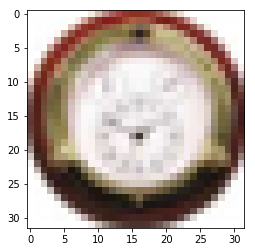

In [89]:
plt.imshow(plt.imread('clock/3975.png'))

In [94]:
densenet = torchvision.models.densenet121(pretrained=True)
densenet.eval()

/Users/pavelshevchuk/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

Всегда приятно посмотреть на устройство очень большой модели.

Для того, чтобы запихнуть нашу штуку в DenseNet нужно поменять порядок данных с $H \times W \times C$ на $N \times C\times H \times W$

In [156]:
def get_features(dirname):
    fnames = [os.path.join(dirname, x) for x in os.listdir(dirname)]
    X_part = np.asarray([plt.imread(x) for x in fnames])
    X_part = np.transpose(X_part, (0, 3, 1, 2))
    with torch.no_grad():
        X_part = densenet.features(torch.tensor(X_part))
    return fnames, X_part.view(X_part.shape[0], -1).numpy()

In [157]:
fnames_clocks, X_clocks = get_features('clock')

In [158]:
fnames_crock, X_crock = get_features('crocodile')

Теперь надо перемешать крокодилов и часы и разделить данные на train и cross-validation

In [174]:
fnames = fnames_clocks + fnames_crock

In [171]:
X = np.concatenate([X_clocks, X_crock], )

In [172]:
y = np.arange(X.shape[0]) >= X_clocks.shape[0]

In [175]:
from sklearn.model_selection import train_test_split

In [187]:
X_train, X_test, y_train, y_test, fnames_train, fnames_test \
    = train_test_split(X, y, fnames, test_size=.3)

Сделано. Теперь надо обучить на этой штуке какую-нибудь простую модель. Простой она обязана быть потому что у нас всё ещё всего лишь тысяча примеров. (а фич 1024). Для простоты обучу-ка я линейную модель, например SVM (разница между различными линейными моделями обычно очень маленькая)

In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [179]:
cls = GridSearchCV(svm.LinearSVC(), param_grid={'C': np.logspace(-5, 2, num=40)}, cv=5, return_train_score=True)

In [180]:
cls.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.51178e-05,   2.28546e-05,   3.45511e-05,
         5.22335e-05,   7.89652e-05,   1.19378e-04,   1.80472e-04,
         2.72833e-04,   4.12463e-04,   6.23551e-04,   9.42668e-04,
         1.42510e-03,   2.15443e-03,   3.25702e-03,   4.92388e-03,
         7.4438...,   1.26638e+01,   1.91448e+01,
         2.89427e+01,   4.37548e+01,   6.61474e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [181]:
cls.best_score_, cls.best_params_

(0.96699999999999997, {'C': 0.0032570206556597828})

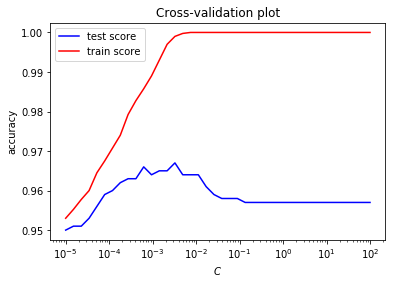

In [182]:
plt.title('Cross-validation plot')
plt.xlabel('$C$')
plt.ylabel('accuracy')
plt.xscale('log')
plt.plot([x['C'] for x in cls.cv_results_['params']],  cls.cv_results_['mean_test_score'], 'b', label='test score')
plt.plot([x['C'] for x in cls.cv_results_['params']],  cls.cv_results_['mean_train_score'], 'r', label='train score')
plt.legend()

Попробуем теперь RBF-ядро

In [227]:
cls_rbf = GridSearchCV(svm.SVC(), {'C': np.logspace(-1, 3, 10), 'gamma': np.logspace(-7, -2, 7)}, return_train_score=True)

In [228]:
cls_rbf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   2.78256e-01,   7.74264e-01,   2.15443e+00,
         5.99484e+00,   1.66810e+01,   4.64159e+01,   1.29155e+02,
         3.59381e+02,   1.00000e+03]), 'gamma': array([  1.00000e-07,   6.81292e-07,   4.64159e-06,   3.16228e-05,
         2.15443e-04,   1.46780e-03,   1.00000e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [229]:
cls_rbf.best_score_, cls_rbf.best_params_

(0.96399999999999997,
 {'C': 5.9948425031894086, 'gamma': 0.00021544346900318845})

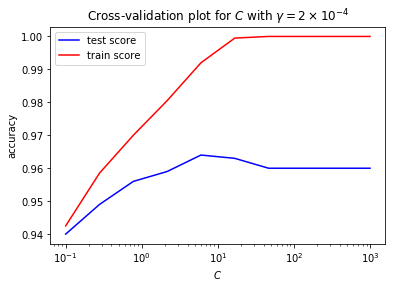

In [235]:
plt.title(r'Cross-validation plot for $C$ with $\gamma = 2 \times 10^{-4}$')
plt.xlabel('$C$')
plt.ylabel('accuracy')
plt.xscale('log')
gamma_pos = [x['gamma'] == cls_rbf.best_params_['gamma'] for x in cls_rbf.cv_results_['params']]
plt.plot([x['C'] for x in cls_rbf.cv_results_['params'] if x['gamma'] == cls_rbf.best_params_['gamma']], 
         cls_rbf.cv_results_['mean_test_score'][gamma_pos], 'b', label='test score')
plt.plot([x['C'] for x in cls_rbf.cv_results_['params'] if x['gamma'] == cls_rbf.best_params_['gamma']], 
         cls_rbf.cv_results_['mean_train_score'][gamma_pos], 'r', label='train score')
plt.legend()

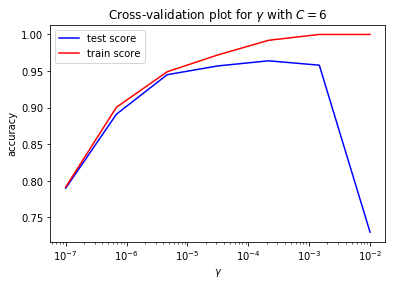

In [236]:
plt.title('Cross-validation plot for $\gamma$ with $C = 6$')
plt.xlabel(r'$\gamma$')
plt.ylabel('accuracy')
plt.xscale('log')
C_pos = [x['C'] == cls_rbf.best_params_['C'] for x in cls_rbf.cv_results_['params']]
plt.plot([x['gamma'] for x in cls_rbf.cv_results_['params'] if x['C'] == cls_rbf.best_params_['C']], 
         cls_rbf.cv_results_['mean_test_score'][C_pos], 'b', label='test score')
plt.plot([x['gamma'] for x in cls_rbf.cv_results_['params'] if x['C'] == cls_rbf.best_params_['C']], 
         cls_rbf.cv_results_['mean_train_score'][C_pos], 'r', label='train score')
plt.legend()

Оптимальным значением $C$ признано $3\times10^{-3}$ при линейном ядре. Обучим новый классификатор и посмотрим где он ошибается

In [209]:
svc = svm.LinearSVC(C=3e-3).fit(X_train, y_train)

In [210]:
svc.score(X_test, y_test)

0.96666666666666667

In [211]:
scores = svc.decision_function(X_test)

In [212]:
worst = np.argsort(scores * (-1) ** y_test)[-10:][::-1]

In [215]:
best = np.argsort(scores * (-1) ** (1+y_test))[-10:][::-1]

In [213]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [214]:
@interact(num=(0, 9))
def show_worst(num=0):
    plt.imshow(plt.imread(fnames_test[worst[num]]))
    return 'crocodile' if y_test[worst[num]] else 'clock'

A Jupyter Widget

In [216]:
@interact(num=(0, 9))
def show_best(num=0):
    plt.imshow(plt.imread(fnames_test[best[num]]))
    return 'crocodile' if y_test[best[num]] else 'clock'

A Jupyter Widget

Вывод: часы проще крокодилов. Сильно ли это портит F1-score?

In [237]:
from sklearn import metrics

In [238]:
metrics.f1_score(y_test, svc.predict(X_test))

0.96932515337423319

Нет

Теперь к крокодилам похожим на часы. Давайте поищем самые близкие к 0 объекты на train set c K-Fold (для того, чтобы исключить overfitting)

In [239]:
from sklearn.model_selection import KFold

In [240]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 1)

In [243]:
distance_to_zero = np.zeros(y.shape[0])
for train_idcs, test_idcs in kfold.split(X):
    cls_tmp = svm.LinearSVC(C=3e-3).fit(X[train_idcs], y[train_idcs])
    distance_to_zero[test_idcs] = np.abs(cls_tmp.decision_function(X[test_idcs]))

In [250]:
closest = np.argsort(distance_to_zero)[:10]

In [251]:
@interact(num=(0, 9))
def show_closest_to_zero(num=0):
    plt.imshow(plt.imread(fnames[closest[num]]))
    return distance_to_zero[closest[num]]

A Jupyter Widget